In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from scipy.stats import binned_statistic

In [18]:
df = pd.read_excel("../data/predictions.xlsx")
df = df[["home_odds", "away_odds", "draw_odds", "over_25_odds", "under_25_odds", "home_goals", "away_goals"]]
df = df.dropna()

odds_cols = [
    "home_odds",
    "away_odds",
    "draw_odds",
    "over_25_odds",
    "under_25_odds"
]

df[odds_cols] = 1 / df[odds_cols]

df['actual_outcome'] = np.where(df['home_goals'] > df['away_goals'], 0,
                               np.where(df['home_goals'] == df['away_goals'], 1, 2))

df['total_goals'] = df['home_goals'] + df['away_goals']
df['actual_over_25'] = (df['total_goals'] > 2.5).astype(int)

df

,home_odds,away_odds,draw_odds,over_25_odds,under_25_odds,home_goals,away_goals,actual_outcome,total_goals,actual_over_25
0,0.266028,0.491642,0.242424,0.633714,0.366435,2,1,0,3,1
1,0.459348,0.276472,0.264201,0.580046,0.420168,2,0,0,2,0
2,0.421941,0.291971,0.286123,0.515198,0.484966,4,0,0,4,1
3,0.686813,0.104899,0.208420,0.473485,0.526593,3,1,0,4,1
4,0.668896,0.119904,0.211015,0.582072,0.417885,2,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...
480,0.386847,0.261097,0.351989,0.203293,0.796813,1,0,0,1,0
481,0.229200,0.450045,0.320718,0.345543,0.654450,1,1,1,2,0
482,0.318573,0.376932,0.304507,0.382848,0.617284,0,1,2,1,0
483,0.240790,0.349040,0.410172,0.156299,0.843882,3,1,0,4,1



EVALUATION OF 1X2 (HOME/DRAW/AWAY) PREDICTIONS

Log Loss (1X2): 1.0599
Average RPS (1X2): 0.1435
RPS Std Dev (1X2): 0.0864

EVALUATION OF OVER/UNDER 2.5 GOALS PREDICTIONS

Log Loss (Over/Under): 0.7760
Brier Score (Over 2.5): 0.2881

CALIBRATION ANALYSIS - 1X2 OUTCOMES

Home Win:
  Expected Calibration Error (ECE): 0.0614
  Bin | Predicted | Actual | Count
  ------------------------------
    1 | 0.150     | 0.258  |  31
    2 | 0.318     | 0.275  | 182
    3 | 0.483     | 0.401  | 207
    4 | 0.671     | 0.700  |  60
    5 | 0.809     | 0.800  |   5

Draw:
  Expected Calibration Error (ECE): 0.0314
  Bin | Predicted | Actual | Count
  ------------------------------
    1 | 0.169     | 0.118  |  34
    2 | 0.275     | 0.303  | 449
    3 | 0.417     | 0.000  |   2

Away Win:
  Expected Calibration Error (ECE): 0.0379
  Bin | Predicted | Actual | Count
  ------------------------------
    1 | 0.140     | 0.184  | 114
    2 | 0.297     | 0.331  | 266
    3 | 0.480     | 0.444  |  90
    

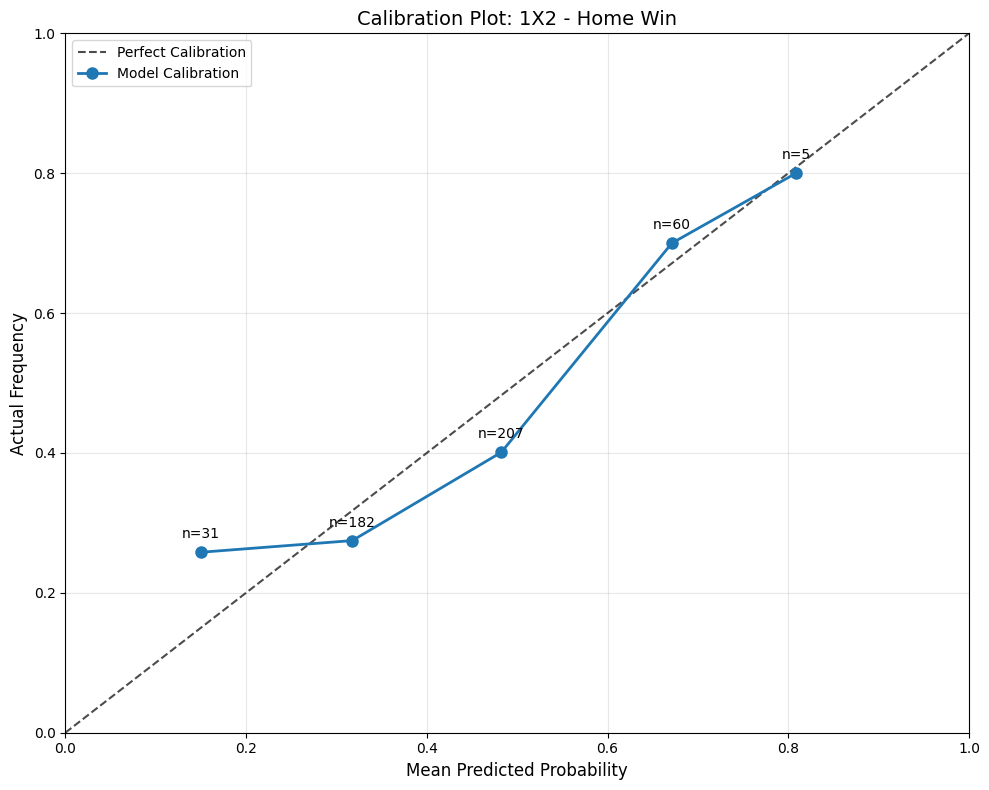

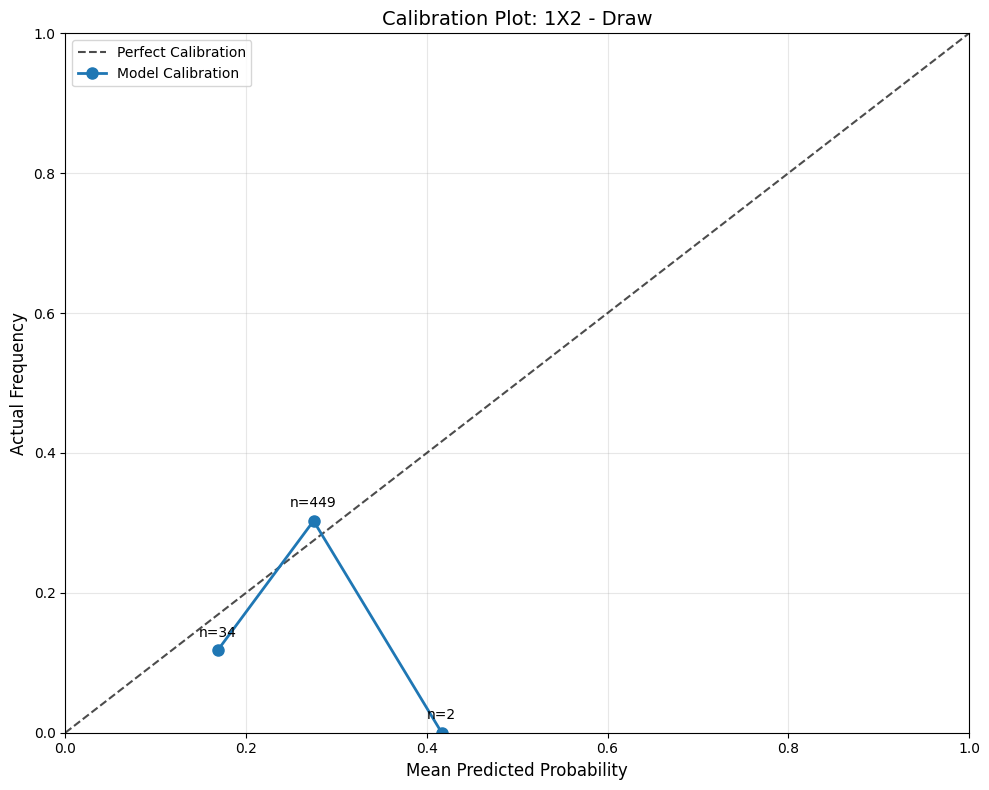

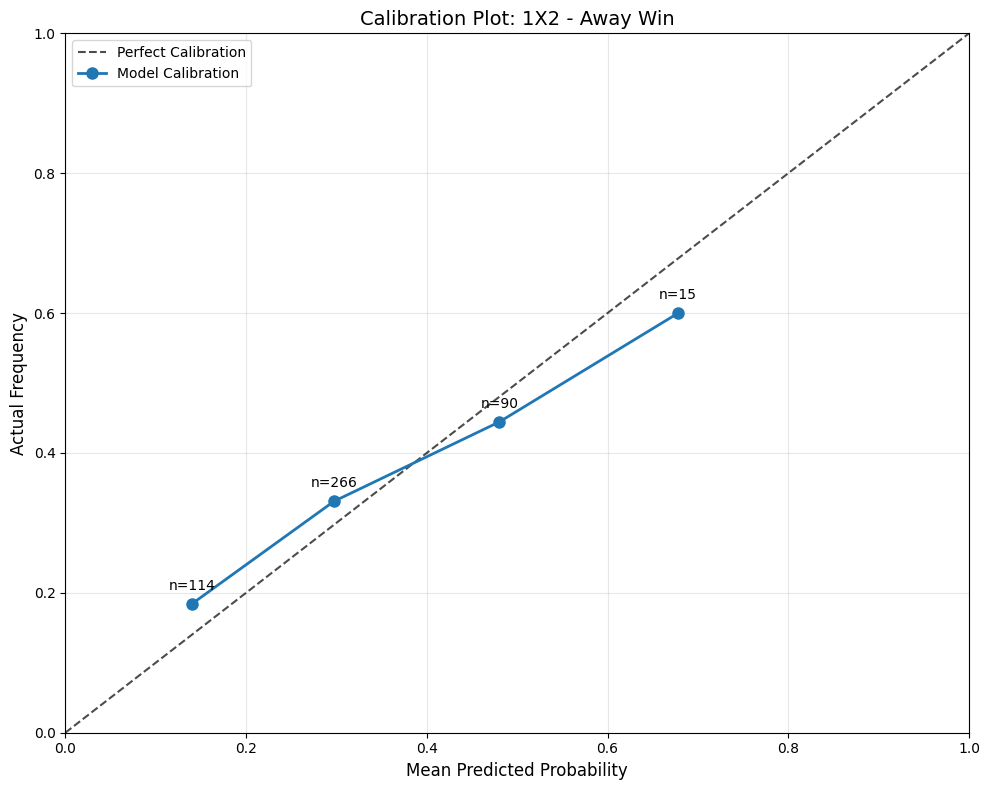

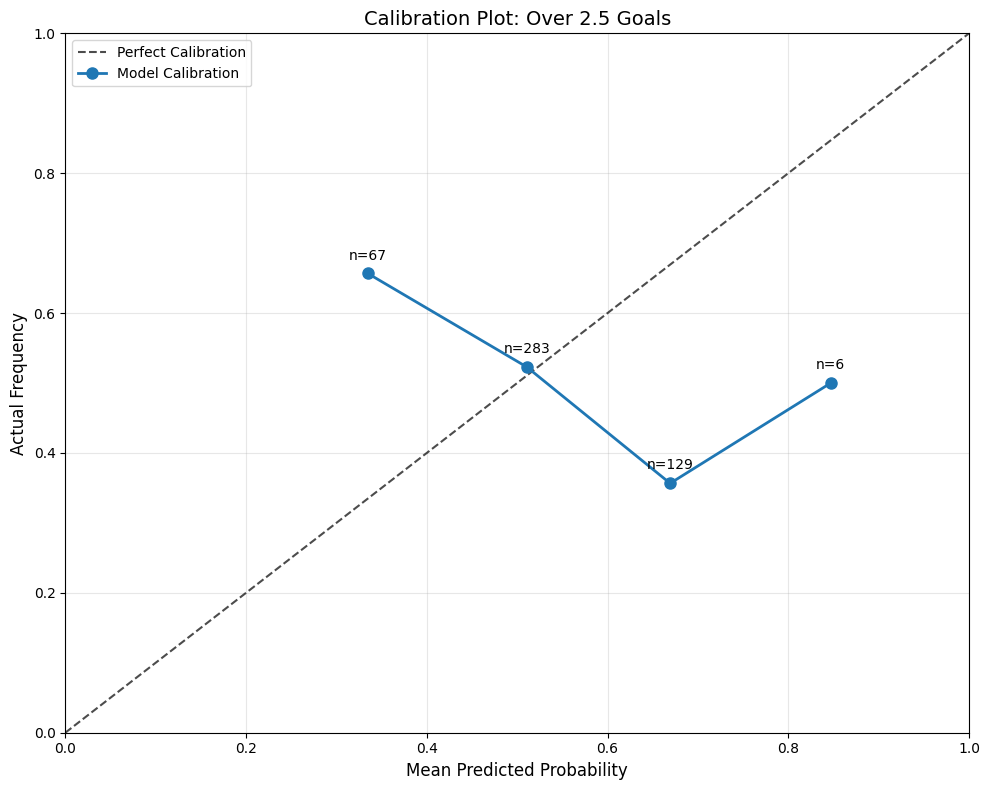


ADDITIONAL ANALYSIS

Distribution of Predicted Probabilities (1X2):
Home win predictions: Mean=0.426, Std=0.151
Draw predictions: Mean=0.268, Std=0.046
Away win predictions: Mean=0.306, Std=0.138

Distribution of Actual Outcomes (1X2):
Home wins: 187 (38.6%)
Draws: 140 (28.9%)
Away wins: 158 (32.6%)

Over/Under 2.5 Analysis:
Over 2.5: 241 (49.7%)
Mean predicted probability for over 2.5: 0.533


In [19]:
def ranked_probability_score(y_true, y_pred):
    """
    Calculate Ranked Probability Score (RPS) for football predictions.
    
    Parameters:
    y_true: Actual outcome encoded as [0=Home, 1=Draw, 2=Away]
    y_pred: Predicted probabilities for [Home, Draw, Away]
    
    Returns:
    RPS value (lower is better)
    """
    # Convert true outcome to cumulative distribution
    actual_cumulative = np.array([0.0, 0.0, 0.0])
    if y_true == 0:  # Home win
        actual_cumulative = np.array([1.0, 1.0, 1.0])
    elif y_true == 1:  # Draw
        actual_cumulative = np.array([0.0, 1.0, 1.0])
    else:  # Away win
        actual_cumulative = np.array([0.0, 0.0, 1.0])
    
    # Convert predicted probabilities to cumulative
    predicted_cumulative = np.cumsum(y_pred)
    
    # Calculate RPS
    rps = np.mean((predicted_cumulative - actual_cumulative) ** 2)
    return rps

def calculate_calibration(y_true, y_pred_prob, n_bins=10):
    """
    Calculate calibration metrics for binary outcomes.
    
    Parameters:
    y_true: Actual outcomes (0 or 1)
    y_pred_prob: Predicted probabilities for the positive class
    n_bins: Number of bins for calibration
    
    Returns:
    DataFrame with calibration statistics
    """
    # Bin the predicted probabilities
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred_prob, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    calibration_data = []
    
    for bin_idx in range(n_bins):
        mask = bin_indices == bin_idx
        if np.sum(mask) > 0:
            bin_mean_pred = np.mean(y_pred_prob[mask])
            bin_actual_rate = np.mean(y_true[mask])
            bin_count = np.sum(mask)
            
            calibration_data.append({
                'bin': bin_idx + 1,
                'bin_start': bins[bin_idx],
                'bin_end': bins[bin_idx + 1],
                'mean_predicted': bin_mean_pred,
                'actual_rate': bin_actual_rate,
                'count': bin_count
            })
    
    return pd.DataFrame(calibration_data)

df_1x2 = df[['home_odds', 'draw_odds', 'away_odds']].copy()
df_1x2_sum = df_1x2.sum(axis=1)
predicted_probs_1x2 = df_1x2.div(df_1x2_sum, axis=0).values

# For over/under predictions
predicted_probs_over = df['over_25_odds'].values.reshape(-1, 1)
predicted_probs_under = df['under_25_odds'].values.reshape(-1, 1)

# Convert to format: [prob_over, prob_under]
predicted_probs_ou = np.column_stack([predicted_probs_over, predicted_probs_under])
predicted_probs_ou = predicted_probs_ou / predicted_probs_ou.sum(axis=1, keepdims=True)

print("\n" + "="*50)
print("EVALUATION OF 1X2 (HOME/DRAW/AWAY) PREDICTIONS")
print("="*50)

# Convert actual outcomes to one-hot for log loss
actual_outcomes = df['actual_outcome'].values
n_matches = len(actual_outcomes)
actual_one_hot = np.zeros((n_matches, 3))
actual_one_hot[np.arange(n_matches), actual_outcomes] = 1

# Calculate Log Loss for 1X2
logloss_1x2 = log_loss(actual_one_hot, predicted_probs_1x2)
print(f"\nLog Loss (1X2): {logloss_1x2:.4f}")

# Calculate RPS for each match and average
rps_scores = []
for i in range(n_matches):
    rps = ranked_probability_score(actual_outcomes[i], predicted_probs_1x2[i])
    rps_scores.append(rps)

print(f"Average RPS (1X2): {np.mean(rps_scores):.4f}")
print(f"RPS Std Dev (1X2): {np.std(rps_scores):.4f}")

# ================================================
# 6. CALCULATE METRICS FOR OVER/UNDER 2.5
# ================================================

print("\n" + "="*50)
print("EVALUATION OF OVER/UNDER 2.5 GOALS PREDICTIONS")
print("="*50)

# For over/under, use binary log loss
actual_over = df['actual_over_25'].values
actual_ou_one_hot = np.zeros((n_matches, 2))
actual_ou_one_hot[np.arange(n_matches), actual_over] = 1

# Calculate Log Loss for over/under
logloss_ou = log_loss(actual_ou_one_hot, predicted_probs_ou)
print(f"\nLog Loss (Over/Under): {logloss_ou:.4f}")

# Brier Score for binary outcome
from sklearn.metrics import brier_score_loss
brier_over = brier_score_loss(actual_over, predicted_probs_ou[:, 1])  # Probability of over
print(f"Brier Score (Over 2.5): {brier_over:.4f}")

# ================================================
# 7. CALIBRATION ANALYSIS
# ================================================

print("\n" + "="*50)
print("CALIBRATION ANALYSIS - 1X2 OUTCOMES")
print("="*50)

# Analyze calibration for each 1X2 outcome separately
for outcome_idx, outcome_name in enumerate(['Home Win', 'Draw', 'Away Win']):
    # Create binary indicator for this outcome
    y_true_binary = (actual_outcomes == outcome_idx).astype(int)
    y_pred_binary = predicted_probs_1x2[:, outcome_idx]
    
    # Calculate calibration
    calib_df = calculate_calibration(y_true_binary, y_pred_binary, n_bins=5)
    
    print(f"\n{outcome_name}:")
    if len(calib_df) > 0:
        # Calculate Expected Calibration Error (ECE)
        total_samples = calib_df['count'].sum()
        ece = np.sum(calib_df['count'] * np.abs(calib_df['mean_predicted'] - calib_df['actual_rate'])) / total_samples
        print(f"  Expected Calibration Error (ECE): {ece:.4f}")
        
        # Show calibration table
        print("  Bin | Predicted | Actual | Count")
        print("  " + "-" * 30)
        for _, row in calib_df.iterrows():
            print(f"  {int(row['bin']):3d} | {float(row['mean_predicted']):.3f}     | {float(row['actual_rate']):.3f}  | {int(row['count']):3d}")

print("\n" + "="*50)
print("CALIBRATION ANALYSIS - OVER/UNDER 2.5")
print("="*50)

# Calibration for over 2.5
calib_df_over = calculate_calibration(actual_over, predicted_probs_ou[:, 1], n_bins=5)

if len(calib_df_over) > 0:
    total_samples = calib_df_over['count'].sum()
    ece_over = np.sum(calib_df_over['count'] * np.abs(calib_df_over['mean_predicted'] - calib_df_over['actual_rate'])) / total_samples
    print(f"\nOver 2.5 Goals:")
    print(f"  Expected Calibration Error (ECE): {ece_over:.4f}")
    
    print("  Bin | Predicted | Actual | Count")
    print("  " + "-" * 30)
    for _, row in calib_df_over.iterrows():
        print(f"  {int(row['bin']):3d} | {float(row['mean_predicted']):.3f}     | {float(row['actual_rate']):.3f}  | {int(row['count']):3d}")

# ================================================
# 8. VISUALIZATION FUNCTIONS
# ================================================

def plot_calibration_curve(y_true, y_pred_prob, outcome_name, n_bins=10):
    """Plot calibration curve for a specific outcome."""
    calib_df = calculate_calibration(y_true, y_pred_prob, n_bins=n_bins)
    
    if len(calib_df) > 0:
        plt.figure(figsize=(10, 8))
        
        # Perfect calibration line
        plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', alpha=0.7)
        
        # Actual calibration curve
        plt.plot(calib_df['mean_predicted'], calib_df['actual_rate'], 
                'o-', linewidth=2, markersize=8, label='Model Calibration')
        
        # Add count annotations
        for _, row in calib_df.iterrows():
            plt.annotate(f"n={int(row['count'])}", 
                        (row['mean_predicted'], row['actual_rate']),
                        textcoords="offset points", xytext=(0,10), ha='center')
        
        plt.xlabel('Mean Predicted Probability', fontsize=12)
        plt.ylabel('Actual Frequency', fontsize=12)
        plt.title(f'Calibration Plot: {outcome_name}', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.show()

# ================================================
# 9. CREATE VISUALIZATIONS
# ================================================

# Plot calibration for 1X2 outcomes
print("\nGenerating calibration plots...")
for outcome_idx, outcome_name in enumerate(['Home Win', 'Draw', 'Away Win']):
    y_true_binary = (actual_outcomes == outcome_idx).astype(int)
    y_pred_binary = predicted_probs_1x2[:, outcome_idx]
    plot_calibration_curve(y_true_binary, y_pred_binary, f"1X2 - {outcome_name}", n_bins=5)

# Plot calibration for over/under
plot_calibration_curve(actual_over, predicted_probs_ou[:, 1], "Over 2.5 Goals", n_bins=5)

# ================================================
# 10. ADDITIONAL ANALYSIS
# ================================================

print("\n" + "="*50)
print("ADDITIONAL ANALYSIS")
print("="*50)

# Distribution of predictions
print("\nDistribution of Predicted Probabilities (1X2):")
print(f"Home win predictions: Mean={predicted_probs_1x2[:, 0].mean():.3f}, Std={predicted_probs_1x2[:, 0].std():.3f}")
print(f"Draw predictions: Mean={predicted_probs_1x2[:, 1].mean():.3f}, Std={predicted_probs_1x2[:, 1].std():.3f}")
print(f"Away win predictions: Mean={predicted_probs_1x2[:, 2].mean():.3f}, Std={predicted_probs_1x2[:, 2].std():.3f}")

print("\nDistribution of Actual Outcomes (1X2):")
print(f"Home wins: {(actual_outcomes == 0).sum()} ({100*(actual_outcomes == 0).mean():.1f}%)")
print(f"Draws: {(actual_outcomes == 1).sum()} ({100*(actual_outcomes == 1).mean():.1f}%)")
print(f"Away wins: {(actual_outcomes == 2).sum()} ({100*(actual_outcomes == 2).mean():.1f}%)")

print("\nOver/Under 2.5 Analysis:")
print(f"Over 2.5: {(actual_over == 1).sum()} ({100*(actual_over == 1).mean():.1f}%)")
print(f"Mean predicted probability for over 2.5: {predicted_probs_ou[:, 1].mean():.3f}")